In [1]:
import seaborn as sns
import matplotlib.style as style
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from matplotlib import pyplot
from pandas import read_csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.preprocessing import LabelBinarizer
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


%matplotlib inline
style.use('fivethirtyeight')


def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        # use first and second column in the dataset
        a = dataset[i:(i+look_back), 0:3]
        dataX.append(a)
        # the output is at the third column of the dataset
        dataY.append(dataset[i + look_back, 3])
    return np.array(dataX), np.array(dataY)


def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [2]:
dataframe_trainset = read_csv(
    '../../../../Objective_1/Existing_DL_Evaluation_CALCE/dataset/different_cycle_train_test/train_FUDS_BJDST_US06.csv', header=0, index_col=0)

dataframe_testset = read_csv(
    '../../../../Objective_1/Existing_DL_Evaluation_CALCE/dataset/different_cycle_train_test/test_DST.csv', header=0, index_col=0)

In [3]:
train_dataset = dataframe_trainset.values
X = train_dataset[:, :2]
# one hot encode the temperature
tempBinarizer = LabelBinarizer().fit(dataframe_trainset['Temp(C)'])
trainCategorical = tempBinarizer.transform(dataframe_trainset['Temp(C)'])
# concatenate the one hot features to V and I
X = np.hstack([X, trainCategorical])
Y = train_dataset[:, 3]


test_dataset = dataframe_testset.values
X_test = test_dataset[:, :2]
# one hot encode the temperature
tempBinarizer = LabelBinarizer().fit(dataframe_testset['Temp(C)'])
testCategorical = tempBinarizer.transform(dataframe_testset['Temp(C)'])
X_test = np.hstack([X_test, testCategorical])
Y_test = test_dataset[:, 3]

# reshape into X=t and Y=t+1
look_back = 15
feature = 3  # voltage and current and temp

trainX, trainY = create_dataset(train_dataset, look_back)
testX, testY = create_dataset(test_dataset, look_back)

In [4]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], feature))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], feature))

In [5]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard, CSVLogger
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, regularizers, BatchNormalization

from keras.layers import Flatten, GlobalAveragePooling1D
from keras.layers.convolutional import Conv1D, Conv2D
from keras.layers.convolutional import MaxPooling1D
from keras.regularizers import l2

from keras.layers import Conv1D, Input, Add, Activation, Dropout, Multiply, Lambda
from keras.initializers import TruncatedNormal
from keras.regularizers import l2
from keras.layers.advanced_activations import LeakyReLU, ELU
from keras.optimizers import Adam
from keras.layers import SimpleRNN, LSTM
from time import time
import livelossplot
from clr_callback import CyclicLR

MIN_LR = 1e-7
MAX_LR = 1e-2
BATCH_SIZE = 64
STEP_SIZE = 4
CLR_METHOD = "triangular2"
NUM_EPOCHS = 1000

TRAINING_PLOT_PATH = os.path.sep.join(["output", "training_plot.png"])
CLR_PLOT_PATH = os.path.sep.join(["output", "clr_plot.png"])

clr = CyclicLR(
    mode=CLR_METHOD,
    base_lr=MIN_LR,
    max_lr=MAX_LR,
    step_size=STEP_SIZE * (trainX.shape[0] // BATCH_SIZE))



plot_losses = livelossplot.PlotLossesKeras()

csv_logger = CSVLogger(
    filename='srnn_3h_saved_models/training.log', separator=',', append=False)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.9, patience=10, verbose=2, cooldown=1)

earlyStopping = EarlyStopping(
    monitor='val_loss', patience=100, verbose=2, mode='auto')

filepath = "srnn_3h_saved_models/weights-improvement-{epoch:04d}-{val_loss:.6f}.hdf5"

checkpoint = ModelCheckpoint(
    filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

callbacks_list = [plot_losses, clr, csv_logger, checkpoint]


model = Sequential()
model.add(SimpleRNN(64, input_shape=(look_back, feature), return_sequences=True))
model.add(SimpleRNN(128, return_sequences=True))
model.add(SimpleRNN(64))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mse', optimizer='adam', metrics=[
              'mse', 'mae', 'mape', 'cosine'])

Using TensorFlow backend.
W0919 10:50:06.669554 140048580908864 deprecation_wrapper.py:119] From /home/camaro/anaconda3/envs/soc-nni/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0919 10:50:06.671060 140048580908864 deprecation_wrapper.py:119] From /home/camaro/anaconda3/envs/soc-nni/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0919 10:50:06.672845 140048580908864 deprecation_wrapper.py:119] From /home/camaro/anaconda3/envs/soc-nni/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0919 10:50:06.895744 140048580908864 deprecation_wrapper.py:119] From /home/camaro/anaconda3/envs/soc-nni/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optim

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 15, 64)            4352      
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 15, 128)           24704     
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 64)                12352     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 41,473
Trainable params: 41,473
Non-trainable params: 0
_________________________________________________________________


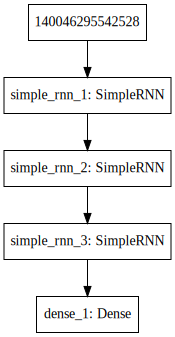

In [7]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

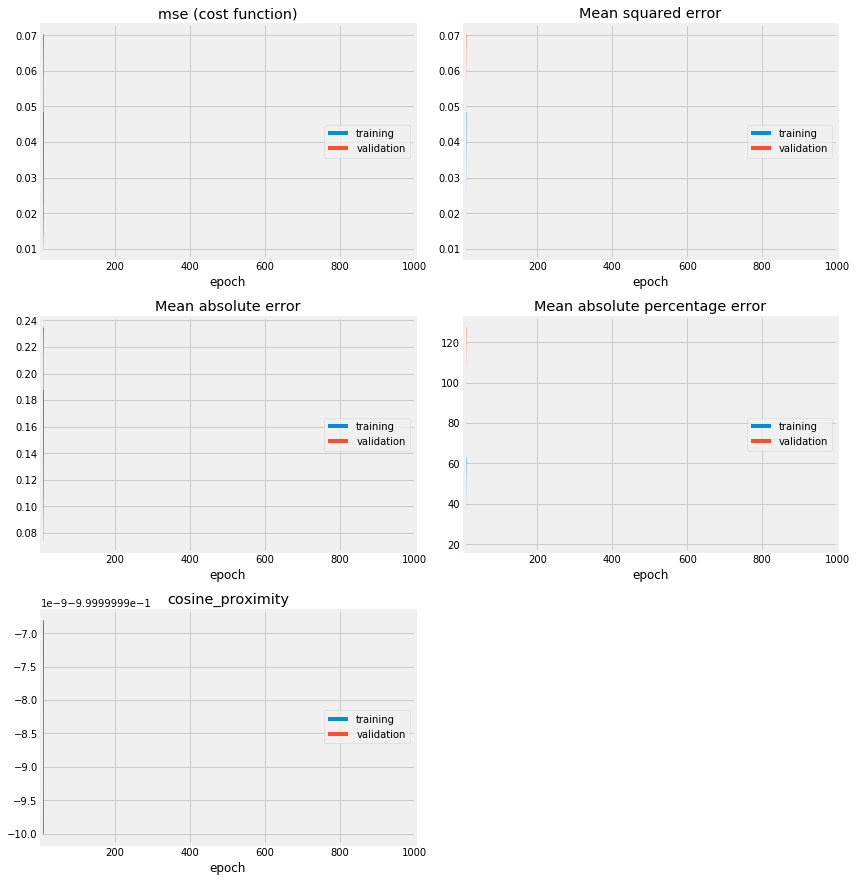

mse (cost function):
training   (min:    0.007, max:    0.048, cur:    0.048)
validation (min:    0.002, max:    0.070, cur:    0.070)

Mean squared error:
training   (min:    0.007, max:    0.048, cur:    0.048)
validation (min:    0.002, max:    0.070, cur:    0.070)

Mean absolute error:
training   (min:    0.062, max:    0.188, cur:    0.188)
validation (min:    0.036, max:    0.235, cur:    0.235)

Mean absolute percentage error:
training   (min:   17.370, max:   63.212, cur:   63.212)
validation (min:   11.890, max:  127.290, cur:  127.290)

cosine_proximity:
training   (min:   -1.000, max:   -1.000, cur:   -1.000)
validation (min:   -1.000, max:   -1.000, cur:   -1.000)

Epoch 00005: val_loss did not improve from 0.00197
Epoch 6/1000


In [ ]:
import time
time_start = time.time()
history = model.fit(trainX,trainY, callbacks=callbacks_list, epochs=1000, validation_split=0.15, batch_size=BATCH_SIZE, verbose=2)

In [ ]:
MSE_scores = []
RMSE_scores = []
MAE_scores = []
MAPE_scores = []
R2_scores = []

print("Training Time: {}".format(time.time()-time_start))

print("----------------------------")
prediction = model.predict(trainX)
df = pd.DataFrame(prediction, columns=["Predicted SOC"])
df['True SOC'] = trainY
df['Rolling Mean Pred'] = df["Predicted SOC"].rolling(window = 100).mean()
df = df.dropna()

# Calculate MSE
mseScore = mean_squared_error(df['True SOC'].values, df['Rolling Mean Pred'].values)
print('Train MSE: %.6f  ' % (mseScore))
MSE_scores.append(mseScore)

# Calculate RMSE
rmseScore = math.sqrt(mean_squared_error(df['True SOC'].values, df['Rolling Mean Pred'].values))
print('Train RMSE: %.6f  ' % (rmseScore))
RMSE_scores.append(rmseScore)

# Calculate MAE
maeScore = math.sqrt(mean_absolute_error(df['True SOC'].values, df['Rolling Mean Pred'].values))
print('Train MAE: %.6f  ' % (maeScore))
MAE_scores.append(maeScore)

# Calculate MAPE
mapeScore = math.sqrt(mean_absolute_percentage_error(df['True SOC'].values, df['Rolling Mean Pred'].values))
print('Train MAPE: %.6f  ' % (mapeScore))
MAPE_scores.append(mapeScore)

# Calculate R2
r2score = r2_score(df['True SOC'].values, df['Rolling Mean Pred'].values)  
print('R2 Coefficient: %.6f ' % (r2score))
R2_scores.append(r2score)



df.plot()

In [ ]:
print("----------------------------")
prediction = model.predict(testX)
df = pd.DataFrame(prediction, columns=["Predicted SOC"])
df['True SOC'] = testY
df['Rolling Mean Pred'] = df["Predicted SOC"].rolling(window=100).mean()
df = df.dropna()

# Calculate MSE
mseScore = mean_squared_error(
    df['True SOC'].values, df['Rolling Mean Pred'].values)
print('Test MSE: %.6f  ' % (mseScore))
MSE_scores.append(mseScore)

# Calculate RMSE
rmseScore = math.sqrt(mean_squared_error(
    df['True SOC'].values, df['Rolling Mean Pred'].values))
print('Test RMSE: %.6f  ' % (rmseScore))
RMSE_scores.append(rmseScore)

# Calculate MAE
maeScore = math.sqrt(mean_absolute_error(
    df['True SOC'].values, df['Rolling Mean Pred'].values))
print('Test MAE: %.6f  ' % (maeScore))
MAE_scores.append(maeScore)

# Calculate MAPE
mapeScore = math.sqrt(mean_absolute_percentage_error(
    df['True SOC'].values, df['Rolling Mean Pred'].values))
print('Test MAPE: %.6f  ' % (mapeScore))
MAPE_scores.append(mapeScore)

# Calculate R2
r2score = r2_score(df['True SOC'].values, df['Rolling Mean Pred'].values)
print('R2 Coefficient: %.6f ' % (r2score))
R2_scores.append(r2score)


df.plot()

In [ ]:
result_df = pd.DataFrame({"Dataset":["Train", "Test"], "MSE":MSE_scores, "RMSE":RMSE_scores, "MAE":MAE_scores, "MAPE":MAPE_scores, "R2":R2_scores})
result_df